# **ABCDEats Inc. - Clustering Analysis**

# 1. Imports, Options and Ingestion

In [90]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

from minisom import MiniSom

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error

In [91]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [92]:
# Reading the csv data

data = pd.read_csv('/home/shadybea/OneDrive/General/Data Mining/Project/DM2425_ABCDEats_DATASET.csv')

# 2. Initial Transformations

In [93]:
_rename_dict = {
        'customer_region' : 'cust_region'
        , 'payment_method' : 'pay_method'
        , 'customer_age' : 'cust_age'
        , 'vendor_count' : 'n_vendor'
        , 'product_count' : 'n_product'
        , 'n_order' : 'n_order'
        , 'is_chain' : 'n_chain'
        , 'CUI_American' : 'american'
        , 'CUI_Asian' : 'asian'
        , 'CUI_Beverages' : 'beverages'
        , 'CUI_Cafe' : 'cafe'
        , 'CUI_Chicken Dishes' : 'chicken_dishes'
        , 'CUI_Chinese' : 'chinese'
        , 'CUI_Desserts' : 'desserts'
        , 'CUI_Healthy' : 'healthy'
        , 'CUI_Indian' : 'indian'
        , 'CUI_Italian' : 'italian'
        , 'CUI_Japanese' : 'japanese'
        , 'CUI_Noodle Dishes' : 'noodle_dishes'
        , 'CUI_OTHER' : 'other'
        , 'CUI_Street Food / Snacks' : 'street_food_snacks'
        , 'CUI_Thai' : 'thai'
}

# Rename the columns for easier reference
data.rename(columns=_rename_dict, inplace=True)

In [94]:
# Make the integer value of the customer hex values, the index. 
data['customer_id'] = data['customer_id'].apply(lambda x: int(x, 16))

# Set 'customer_id' as the index
data = data[~data['customer_id'].duplicated()].set_index('customer_id')

## 2.1. Missing Values

In [95]:
# Fill missing values for first_order
data.loc[data['first_order'].isna(), 'first_order'] = 0

In [96]:
# Fill missing values for HR_0
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data.loc[data['HR_0'].isna(), 'HR_0'] = (sum_week - sum_day)

## 2.2. Inconsistencies

### 2.2.1. Duplicate Values

In [ ]:
len(data[data.duplicated(keep=False)])

In [ ]:
len(data[data.duplicated()])

In [ ]:
data[data.duplicated(keep=False)].head()

We find 94 such rows, regarding 47 entries; and simply drop the repeats.

In [100]:
data = data.drop_duplicates()

### 2.2.2. Inconsistent Values

In [ ]:
# has at least one vendor
has_vendor = data['n_vendor'] != 0 

# has at least one product
has_product = data['n_product'] != 0 

# purchase must have been made on a valid dow
some_day = (data[[f"DOW_{n}" for n in range(7)]] != 0).any(axis = 1) 

# purchase must have been made at a valid hour
some_hour = (data[[f"HR_{n}" for n in range(24)]] != 0).any(axis = 1)  

# some type of cuisine must have been ordered
some_food = (data[data.columns[9:24]] != 0).any(axis = 1) 

# We find 156 such values
data[~(has_vendor & has_product & some_day & some_hour & some_food)].shape[0] 

In [ ]:
data[~(has_vendor & has_product & some_day & some_hour & some_food)].head()

In [103]:
data = data[(has_vendor & has_product & some_day & some_hour & some_food)]  # And we drop these values

In [ ]:
# Check if the sum of the order counts for DOW, match the sum of the order counts for HR.
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data[(sum_day != sum_week)].shape[0]  # Bam

In [ ]:
# Check if there are any customers, for whom 'last_order' was placed before 'first_order'.
data[data['last_order'] < data['first_order']].shape[0]  # Double Bam

### 2.2.3. Weird Values

In [106]:
# Customer Region
data.loc[data['cust_region'] == '-', 'cust_region'] = '8670'
data.loc[data['cust_region'].isin(['2440', '2490']), 'cust_region'] = '2400'

# Add the feature Customer CIty
data['cust_city'] = data['cust_region'].apply(lambda x: x[0])

In [107]:
# Last Promo
data.loc[data['last_promo'] == '-', 'last_promo'] = 'NO_PROMO'

## 2.3. Data Types

In [108]:
# Tidying up datatypes
for col in data.iloc[:, 0:9]:
    if col in ['last_promo', 'pay_method']:
        data[col] = data[col].astype(object)
    else:
        data[col] = data[col].astype('Int64')

for col in data.iloc[:, 9:24]:
    data[col] = data[col].astype(float)

for col in data.iloc[:, 24:]:
    data[col] = data[col].astype('Int64')

In [ ]:
data.info()

In [ ]:
data.head()

# 3. Feature Engineering

We create lists of features for easy reference.

In [111]:
# Categorical variables
non_metric_features = ['cust_region', 'last_promo', 'pay_method', 'cust_city']

# Hour of day variables
hour_features = data.columns[31:55].to_list()

# Day of week variables
day_features = data.columns[24:31].to_list()

# Cuisine features
cuisine_features = data.columns[9:24].to_list()

# Metric variables, that are not above
metric_features = data.columns.drop(non_metric_features).drop(hour_features).drop(day_features).drop(cuisine_features).to_list()

In [112]:
# Total amount spent by customer on all types of cuisine
data['total_amt'] = data[cuisine_features].sum(axis=1)

# Number of orders made by the customer
data['n_order'] = data[day_features].sum(axis=1)

# Amount spent on average per product
data['avg_amt_per_product'] = data['total_amt'] / data['n_product']

# Amount spent on average per order
data['avg_amt_per_order'] = data['total_amt'] / data['n_order']

# Amount spent on average per vendor
data['avg_amt_per_vendor'] = data['total_amt'] / data['n_vendor']

# Total days as customer
data['days_cust'] = data['last_order'] - data['first_order']

# Average days between orders
data['avg_days_to_order'] = data['days_cust'] / data['n_order']

# Days the customer is due, according to their average days between orders
data['days_due'] = 90 - data['last_order'] + data['avg_days_to_order']

# Percentage of orders placed to restaurants that are part of a chain
data['per_chain_order'] = data['n_chain'] / data['n_order']

# And we add these tese features to the metric features list.
metric_features.extend(
    [
        'n_order'
        , 'per_chain_order'
        ,'total_amt'
        , 'avg_amt_per_order'
        , 'avg_amt_per_product'
        , 'avg_amt_per_vendor'
        , 'days_cust'
        , 'avg_days_to_order'
        , 'days_due'
    ]
)

In [113]:
# Create a mask to check if each day column is populated
mask = data[[f'DOW_{i}' for i in range(7)]] > 0

# Sum over the mask to get the count of days with purchases for each row
data.loc[:, 'n_days_week'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_days_week')

In [114]:
# Create a mask to check if each hour column is populated
mask = data[hour_features] > 0

# Sum over the mask to get the count of hours with purchases for each row
data.loc[:, 'n_times_day'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_times_day')

In [115]:
# Flag customers who have purchased in more than one day
data['regular'] = (data['days_cust'] != 0)

non_metric_features.append('regular')

In [116]:
# Create a mask where values are greater than zero (indicating an order)
mask = data[cuisine_features] > 0

# # Use mask to get the ordered cuisines for each row
# data.loc[:, 'ordered_cuisines'] = mask.apply(lambda row: [cuisine for cuisine, ordered in row.items() if ordered], axis=1)

# # Updating the non_metric_features_list
# non_metric_features.append('ordered_cuisines')

# Use mask to get the number of cuisines for each row
data.loc[:, 'n_cuisines'] = mask.sum(axis=1)

# Updating the metric_features_list
metric_features.append('n_cuisines')

In [117]:
# Dropping specified columns and getting remaining columns as a list
targets = data.drop(columns=[
    'cust_age'
    , 'first_order'
    , 'last_order'
    , 'days_cust'
    , 'days_due'
    , 'avg_days_to_order'
    , 'per_chain_order'
    , 'cust_region'
    , 'cust_city'
    , 'last_promo'
    , 'pay_method'
    # , 'ordered_cuisines'
    , 'n_cuisines'
    , 'regular'
] + hour_features + day_features).columns.tolist()

# Initialize an empty DataFrame to store log-transformed columns
log_transformed = pd.DataFrame()

# Apply log1p to each column in targets and add it to log_transformed with the prefix 'log_'
for col in targets:
    log_transformed[f"log_{col}"] = np.log1p(data[col])

# We create a list of log_features to assist us in our exploration
log_features = log_transformed.columns.tolist()

# Concatenate the original DataFrame with the new log-transformed DataFrame
data = pd.concat([data, log_transformed], axis=1)

In [ ]:
# Initialize dictionaries for feature groups with flags and relevant columns
feature_groups = {
    'foodie': ['n_vendor', 'n_product', 'n_order', 'n_cuisines'],
    'gluttonous': ['avg_amt_per_order', 'total_amt', 'n_chain'],
    'loyal': ['avg_amt_per_vendor'] + cuisine_features
}


# Create columns to hold the flags for each feature group
data['foodie_flag'] = 0
data['gluttonous_flag'] = 0
data['loyal_flag'] = 0

# Function to calculate IQR bounds
def calculate_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Assign flags for each feature group
for group, features in feature_groups.items():
    for feature in features:
        log_feature = f"log_{feature}"
        
        if feature == 'n_cuisines':
            log_feature = feature
        
        lower_bound, upper_bound = calculate_bounds(data.loc[(data['regular'] == 1) & (data[feature] > 0), log_feature])
        
        # Mark outliers for each group
        if group == 'foodie':
            data.loc[data['regular'] == 1, 'foodie_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'gluttonous':
            data.loc[data['regular'] == 1, 'gluttonous_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'loyal':
            data.loc[data['regular'] == 1, 'loyal_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)

# Display results
for group in ['foodie_flag', 'gluttonous_flag', 'loyal_flag']:
    print(f"Number of customers flagged as {group.split('_')[0]}:", data[group].sum())

non_metric_features.extend([
    'foodie_flag'
    ,'gluttonous_flag'
    ,'loyal_flag'
])

In [119]:
def top_n(row, col_list, n):
    # Sort the specified columns in descending order
    sorted_row = row[col_list].sort_values(ascending=False)

    # Get the unique sorted values
    unique_sorted_values = sorted_row.unique()

    # Ensure there are enough unique values to determine the n-th largest
    if len(unique_sorted_values) >= n:
        nth_value = unique_sorted_values[n - 1]  # Get the n-th largest unique value

        # If the n-th value is 0, return None
        if nth_value == 0:
            return None
        
        # If n > 1, check for uniqueness against the (n-1)-th largest
        if n > 1:
            prev_value = unique_sorted_values[n - 2]  # (n-1)-th largest unique value
            # If nth_value is equal to the (n-1)-th value, we don't want to return it
            if nth_value == prev_value:
                return None
        
        # Return the index of the n-th largest value
        return sorted_row[sorted_row == nth_value].index[0]

    # Return None if conditions are not met
    return None

In [120]:
data['top_cuisine'] = data.apply(top_n, col_list=cuisine_features, n=1, axis=1)

non_metric_features.append('top_cuisine')

In [121]:
# Average amount spent per day as customer
data['avg_amt_per_day'] = np.round(data['total_amt'] / data['days_cust'], 4)

# Average number of products ordered per day as customer
data['avg_product_per_day'] = np.round(data['n_product'] / data['days_cust'], 4)

# Average number of orders per day as customer
data['avg_order_per_day'] = np.round(data['n_order'] / data['days_cust'], 4)

metric_features.extend([
    'avg_amt_per_day'
    ,'avg_product_per_day'
    ,'avg_order_per_day'
])

# 4. Preprocessing

Before starting the preprocessing efforts, there are some customers that can be perceived as outliers, namely the ones that were flagged as part of a group or non-regulars. Therefore, we create an auxiliary dataframe excluding these, which we will use in a fashion resembling a train-test split, where these are the training data.

In [122]:
# Create dataframe with only customers which are regular and do not belong to another group
aux_df = data[data['regular'] == 1]

## 4.1. Outliers

Based on the boxplots of the EDA part of the project, we can filter our dataset using the following conditions.

In [123]:
og_rows = data.shape[0]

In [124]:
def compute_percentile_bounds(reference_data, filters):
    """
    Compute percentile bounds for the given filters using the reference dataset.

    :param reference_data: DataFrame used to compute the percentiles.
    :param filters: Dictionary of column names and (lower_percentile, upper_percentile).
    :return: Dictionary with column names and the corresponding (lower_bound, upper_bound).
    """
    bounds = {}
    
    for col, percentiles in filters.items():
        if col not in reference_data.columns:
            raise ValueError(f"Column '{col}' not found in the reference DataFrame.")

        lower_percentile, upper_percentile = percentiles
        lower_bound = reference_data[col].quantile(lower_percentile) if lower_percentile is not None else None
        upper_bound = reference_data[col].quantile(upper_percentile) if upper_percentile is not None else None
        bounds[col] = (lower_bound, upper_bound)

    return bounds

def filter_by_bounds(data, bounds):
    """
    Filter the data using precomputed bounds.

    :param data: DataFrame to be filtered.
    :param bounds: Dictionary with column names and the corresponding (lower_bound, upper_bound).
    :return: Filtered DataFrame.
    """
    conditions = []

    for col, (lower_bound, upper_bound) in bounds.items():
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

        if lower_bound is not None:
            conditions.append(data[col] >= lower_bound)
        if upper_bound is not None:
            conditions.append(data[col] <= upper_bound)

    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        return data[combined_condition]

    return data

# Example Usage:
# Compute bounds using dataset a
defined_filters = {
    **{col: (None, 0.999) for col in aux_df.columns if 'log' in col}
}
percentile_bounds = compute_percentile_bounds(aux_df, defined_filters)

# Filter dataset b using the computed bounds
data = filter_by_bounds(data, percentile_bounds)


In [ ]:
print('Percentage of data kept after removing outliers:', 100 * np.round(data.shape[0] / og_rows, 4))

Let us recheck the boxplots

In [ ]:
target = data.drop(columns=non_metric_features).columns
num_features = len(target)
num_columns = 4
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

axes = axes.flatten()

# Loop through each numeric feature to plot histograms
for ax, feature in zip(axes, target):
    sns.boxplot(y=data[feature], color='#666666', ax=ax)  
    ax.set_title(f'{feature}')

# Hide any empty subplots
for i in range(len(target), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Boxplots of All Features (exluding Non-Metric Features)')
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Show the plot
plt.show()

## 4.2. Missing Values

In [127]:
# Recreate dataframe with only customers which are regular and do not belong to another group
aux_df = data[data['regular'] == 1]

In [ ]:
data.isna().sum()

There are missing values for 'cust_age', which will be imputed using a strategy to be determined next.

In [ ]:
np.random.seed(20)

test_df = pd.DataFrame(aux_df['cust_age'].copy(deep=True).dropna())

data_with_missing = test_df.copy()
data_with_missing.loc[np.random.choice(data_with_missing.index, size=2000, replace=False)] = np.nan

mean_imputed = data_with_missing.fillna(data_with_missing.mean().astype('int'), inplace=False)
median_imputed = data_with_missing.fillna(data_with_missing.median(), inplace=False)

# Distance-based imputation (k-NN)
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_with_missing), columns=data_with_missing.columns)


rmse_mean = root_mean_squared_error(test_df['cust_age'], mean_imputed['cust_age'])
rmse_median = root_mean_squared_error(test_df['cust_age'], median_imputed['cust_age'])
rmse_knn = root_mean_squared_error(test_df['cust_age'], knn_imputed['cust_age'])

print(f"Mean Imputation RMSE: {rmse_mean:.4f}")
print(f"Median Imputation RMSE: {rmse_median:.4f}")
print(f"KNN Imputation RMSE: {rmse_knn:.4f}")

According to the results above, the difference between filling the missing values with the mean over the median yields better results and is not much different than imputing them using the KNN algorithm. Since the computational complexity is lower, we opt to fill the missing values of the original dataframe using the mean.

In [130]:
data.loc[data['cust_age'].isna(), 'cust_age'] = aux_df['cust_age'].mean().astype('int')

## 4.3. Categorical Encoding

In [131]:
# Recreate the auxiliary dataframe
aux_df = data[data['regular'] == 1]

In [132]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
# ohe.fit(aux_df[non_metric_features[:4]])
ohe_df = ohe.fit_transform(data[non_metric_features[:4]])

ohe_feat_names = ohe.get_feature_names_out()

In [ ]:
ohe_df.head()

In [ ]:
data = pd.concat([data.drop(columns=non_metric_features[:4]), ohe_df], axis=1)

data.head()

Before moving on with the remaining preprocessing, we will make a split in our data. As mentioned in our EDA report, we believe the one-time customers are a special group of customers and that keeping them through out the entirety of our analysis could compromise it negatively. Therefore, we will create a new dataset that does not contain this set of customers and will return to them later.

In [135]:
regulars = data[data['regular'] == 1].copy(deep=True)

## 4.4. Data Normalization

For this step, we create two datasets, one using StandardScaler and another using MinMaxScaler. The clustering efforts will be applied to both and we will then choose the one which yields the best results.

In [136]:
scaler = StandardScaler().set_output(transform='pandas')
regulars = pd.concat([scaler.fit_transform(regulars.drop(columns=list(ohe_feat_names) + non_metric_features[4:])), regulars[list(ohe_feat_names) + non_metric_features[4:]]], axis=1)

## 4.5. Multidimensional Outliers

Now, Local Outlier Factor can be applied to remove the multidimensional outliers, since the data is scaled.

In [137]:
regulars_og = regulars.shape[0]

In [138]:
lof_std = LocalOutlierFactor(n_neighbors=5)

outlier_predictions = lof_std.fit_predict(regulars.drop(columns=list(ohe_feat_names) + non_metric_features[4:]))

# Mark outliers
regulars['Outlier'] = np.where(outlier_predictions == -1, True, False)

# Remove outliers
regulars = regulars[regulars['Outlier'] == False].drop(columns=['Outlier'])

In [ ]:
print('Percentage of data kept after removing outliers:', 100 * np.round(regulars.shape[0] / regulars_og, 4))

## 4.6. Feature Selection

In [ ]:
# compute the correlation matrix for the metric features
corr_matrix = regulars[metric_features].corr(method='pearson')

plt.figure(figsize=(15,12))

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

annot = np.full(corr_matrix.shape, '', dtype=object)

# Fill the annotation array with formatted values for correlations above the threshold
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if abs(corr_matrix.iat[i, j]) >= 0.3:
            annot[i, j] = f"{corr_matrix.iat[i, j]:.2f}" 

# create the heatmap
sns.heatmap(data=corr_matrix, annot=annot, cmap='vlag', 
            fmt="", center=0, vmin=-1, vmax=1, square=True, 
            linewidths=.5, mask=mask, annot_kws={"size": 10})

# Show the plot
plt.title('Metric Features Pearson Correlation Heatmap')
plt.show()

We will perform PCA with the variables avg_amt_per_day, avg_product_per_day, avg_order_per_day, n_product and n_order - in order to reduce dimensionality and assess if the resulting principal components are of any help.

In [141]:
pca = PCA(random_state=20)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])

In [ ]:
# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# get the cumulative explained variance ratio 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

In [ ]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio,  # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio,  # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [ ]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3, random_state=20)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=regulars.index, columns=pca_feat_names)  
pca_df.head()

In [ ]:
# Reassigning df to contain pca variables
df_pca = pd.concat([regulars, pca_df], axis=1)
df_pca.head()

In [146]:
loadings = df_pca[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'] + pca_feat_names].corr().loc[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'], pca_feat_names]

In [ ]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings.style.map(_color_red_or_green)

In [148]:
df_pca.drop(columns='PC2', inplace=True)

In [149]:
df_pca.rename(columns={'PC0': 'transaction_volume', 'PC1': 'interaction_rate'}, inplace=True)

In [ ]:
df_pca.head()

In [151]:
regulars = df_pca

# 5. Clustering

## 5.1. Spending and Order Diversity Clustering

In [152]:
spending_diversity = ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']

In [153]:
spending_diversity_std_df = regulars[spending_diversity]

In [154]:
# Function to calculate R² for a clustering solution
def get_rsq(df, features, label_column):
    """Calculates R² for a clustering solution.
    
    R² = SSb / SSt
    where:
    SSb = between-group sum of squares
    SSt = total sum of squares
    
    Parameters:
    df (DataFrame): The dataframe containing the features and cluster labels
    features (list): List of feature columns to consider
    label_column (str): The column containing the cluster labels
    
    Returns:
    float: R² value indicating homogeneity of the clusters
    """
    # Total Sum of Squares (SSt)
    mean = df[features].mean().values
    sst = np.sum((df[features].values - mean) ** 2)

    # Between-group Sum of Squares (SSb)
    ssb = 0
    for label in df[label_column].unique():
        group = df[df[label_column] == label]
        group_mean = group[features].mean().values
        ssb += len(group) * np.sum((group_mean - mean) ** 2)
        
    # R² Calculation
    r2 = ssb / sst if sst != 0 else 0
    return r2

In [ ]:
# Running R² Calculation for Different Hierarchical Clustering Methods
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 8

# Initialize an empty list to store R² values for each method
r2_hc = []

# Compute R² for each clustering method and range of clusters
for link in hc_methods:
    r2_method = []
    for i in range(1, max_nclus + 1):  # Loop over cluster counts
        cluster = AgglomerativeClustering(n_clusters=i, metric="euclidean", linkage=link)
        
        # Get cluster labels
        hclabels = cluster.fit_predict(spending_diversity_std_df) 
        
        # Concatenate the df with the cluster labels
        df_concat = pd.concat([spending_diversity_std_df, pd.Series(hclabels, name='labels', index=spending_diversity_std_df.index)], axis=1)  
        
        # Compute R² for the current number of clusters
        r2_method.append(get_rsq(df_concat, spending_diversity_std_df.columns.tolist(), 'labels'))
    
    r2_hc.append(r2_method)

# Convert R² results into a numpy array for easier manipulation
r2_hc = np.vstack(r2_hc)

In [ ]:
# Plotting the R² values for Hierarchical Clustering Methods
sns.set()

# Create a figure for the plot
fig = plt.figure(figsize=(11, 5))

# Plot the R² values for each clustering method
for i, link in enumerate(hc_methods):
    sns.lineplot(data=r2_hc[i], linewidth=2.5, markers=["o"] * max_nclus, label=link)

# Finalize the plot
plt.legend(title="HC Methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of Clusters", fontsize=13)
plt.ylabel("R² Metric", fontsize=13)
fig.suptitle("$R^2$ Plot for Various Hierarchical Methods", fontsize=21)

plt.show()

In [ ]:
# Plotting the Dendrogram for Hierarchical Clustering
# Using the 'ward' method for dendrogram plotting (you can adjust this method)
linkage_matrix = linkage(spending_diversity_std_df.values, method="ward", metric="euclidean")

sns.set()
fig = plt.figure(figsize=(11, 5))
# Set a threshold for cutting the dendrogram
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
plt.xlabel('Number of Points in Node')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [ ]:
avg_silhouette = []
for nclus in range(3, 9):
    # Skip nclus == 1
    if nclus == 1:
        continue

    cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
    hc_labels = cluster.fit_predict(spending_diversity_std_df)

    # Calculate centroids based on these hierarchical clusters
    centroids = []
    for i in range(nclus):
        cluster_points = spending_diversity_std_df[hc_labels == i]  # Get points belonging to cluster i
        centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
    cluster_labels = kmclust.fit_predict(spending_diversity_std_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(spending_diversity_std_df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

In [ ]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(3, 9), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [163]:
n_clusters = 7

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_std_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_std_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [ ]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_std_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_std_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

In [ ]:
df_concat = pd.concat([
    spending_diversity_std_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_std_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').median()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').median().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

In [ ]:
import itertools

combinations = list(itertools.combinations(df_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.5,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
df_means = df_concat.mean()
df_means.name="Data"

pd.concat([hc_profile, df_means], axis=1)

In [168]:
# Identify promo columns
promo_columns = [col for col in regulars.columns if col.startswith('cust_city_')]

df_concat = pd.concat([df_concat, regulars[promo_columns]], axis=1)

In [ ]:
df_filtered = df_concat[df_concat[promo_columns].sum(axis=1) > 0]

# Group by 'labels' and compute mean for each one-hot encoded column
cluster_profile = df_filtered.groupby('labels')[promo_columns].mean().reset_index()

# Display cluster profiling
print("Cluster Profiling Based on Last Promo:")
print(cluster_profile)

In [ ]:
# Create an empty DataFrame to store results
result_list = []

# Loop through each promo column to filter and compute medians
for promo in promo_columns:
    # Filter customers with non-zero values for the specific promo column
    filtered_df = df_concat[df_concat[promo] > 0]
    
    # Group by 'labels' and compute the median 'total_amt' for this promo
    median_total_amt = (
        filtered_df
        .groupby('labels')['total_amt']
        .median()
        .reset_index()
    )
    
    # Add the promo column name for clarity
    median_total_amt['promo_type'] = promo
    result_list.append(median_total_amt)

# Concatenate results for all promos
final_result = pd.concat(result_list, ignore_index=True)

# Display results
print("Median Total Amount by Labels and Promo Types:")
display(final_result)

## 5.2. Engagement Clustering

In [172]:
engagement_features = [
    *[col for col in regulars.columns if col.startswith('DOW_')]
    ,*[col for col in regulars.columns if col.startswith('HR_')]
    ,'american', 'asian', 'beverages', 'cafe', 'chicken_dishes', 'chinese'
    ,'desserts', 'healthy', 'indian', 'italian', 'japanese'
    ,'noodle_dishes', 'other', 'street_food_snacks', 'thai'
    # ,'log_american', 'log_asian', 'log_beverages', 'log_cafe', 'log_chicken_dishes', 'log_chinese'
    # ,'log_desserts', 'log_healthy', 'log_indian', 'log_italian', 'log_japanese'
    # ,'log_noodle_dishes', 'log_other', 'log_street_food_snacks', 'log_thai'
    # ,'days_cust'
    # ,'n_order'
    # ,'avg_amt_per_order'
    # ,'avg_amt_per_product'
    # ,'avg_amt_per_vendor'
]

In [173]:
engagement_minmax_df = regulars[engagement_features]

In [174]:
# Some helper functions
def tidy_ax(ax, major_ticks, minor_ticks, minor_lim=None):

    ax.set_xticks(major_ticks-.5)
    ax.set_xticks(minor_ticks-.5, minor=True)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.grid(which='both', alpha=0.5, color='white', linewidth=1)

    ax.tick_params(axis='both', which='both', direction="in", width=0, length=0)

    if minor_lim == None:
        minor_lim = major_ticks.max()

    ax.set_yticks(major_ticks[major_ticks<minor_lim]-.5, )
    ax.set_yticks(minor_ticks[minor_ticks<minor_lim]-.5, minor=True)
    
    ax.set_aspect(1)

    return ax

In [175]:
# Define the Euclidean Distance
def euclidean(x, w):
    """
    Calculate the Euclidean distance between two vectors.
    """
    return np.linalg.norm(np.subtract(x, w), axis=-1)

# Define the Jaccard Distance
def jaccard(x, w):
    """
    Calculate the Jaccard distance between two vectors.
    Assumes x and w are binary vectors (0 or 1).
    """
    x = np.asarray(x)
    w = np.asarray(w)

    # Calculate intersection and union
    intersection = np.sum(np.logical_and(x, w), axis=-1)
    union = np.sum(np.logical_or(x, w), axis=-1)

    # Return Jaccard distance: 1 - similarity
    return 1 - (intersection / (union + 1e-8))

# Define the Hybrid Distance (Weighted Combination of Euclidean and Jaccard)
def hybrid_distance(x, w, alpha=0.98):
    """
    Combine Euclidean Distance and Jaccard Distance into a single hybrid metric.

    Parameters:
        x (numpy array): Input vector.
        w (numpy array): Weight vector.
        alpha (float): Weight for Euclidean Distance (0 <= alpha <= 1).

    Returns:
        float: Hybrid distance.
    """
    # Compute Euclidean distance
    eucl_dist = euclidean(x, w)

    # Compute Jaccard distance
    jac_dist = jaccard(x, w)

    # Combine the two distances
    return alpha * eucl_dist + (1 - alpha) * jac_dist

# Example sparse data (non-binary sparse vector)
# data = np.random.rand(100, 10)  # 100 samples, 10 features (continuous values)

# # Initialize the SOM with the custom hybrid distance function
# som = MiniSom(x=10, y=10, input_len=10, sigma=1.0, learning_rate=0.5,
#               distance_metric=hybrid_distance)

# # Initialize the SOM weights and train
# som.random_weights_init(data)
# som.train_random(data, num_iteration=100)

# # After training, you can get the final weight vectors and use the SOM as needed
# print("Training complete.")

In [176]:
M = 30
N = 30
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(engagement_features)
learning_rate = .5

som_data = engagement_minmax_df.values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=20
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 

print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))

# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

# sm.train_batch(som_data, 2500)
sm.train_random(data=som_data, num_iteration=100)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))

Before training:


/home/shadybea/anaconda3/envs/dm/lib/python3.12/site-packages/minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


QE 3.9357
TE 0.9958
After training:
QE 3.9241
TE 0.9939


In [177]:
weights = sm.get_weights()
weights.shape

(30, 30, 46)

In [178]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize=5)


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)

    return sf 

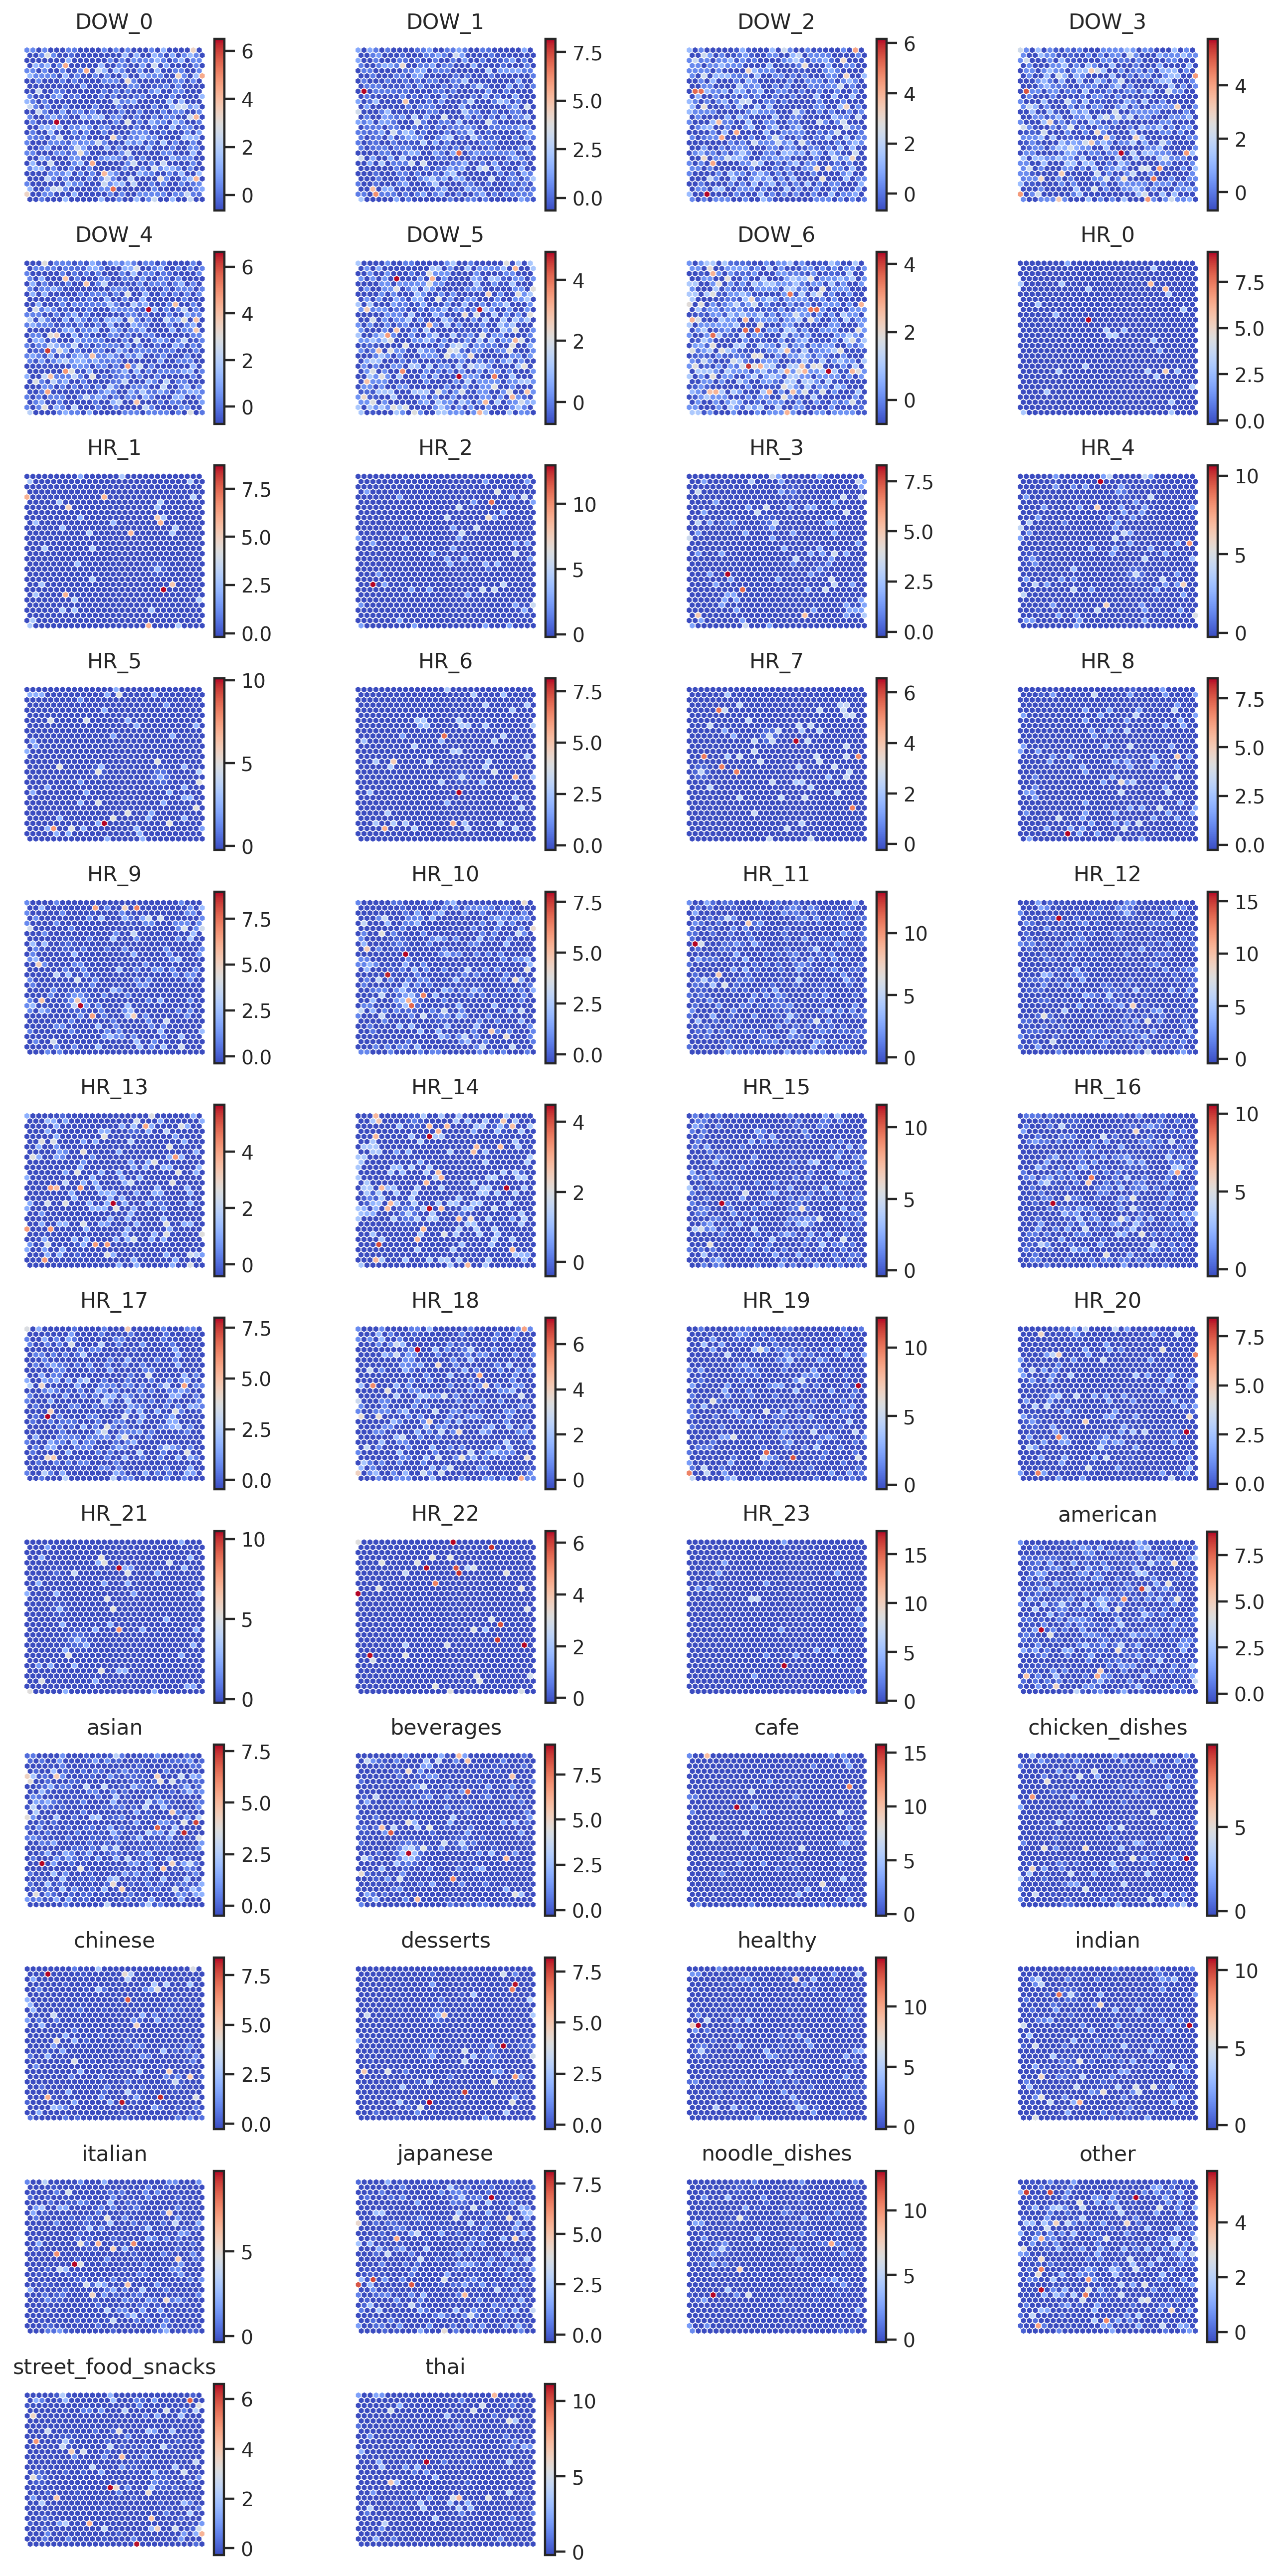

In [179]:
##############################
# Plot Component Planes
##############################

figsize=(10,20)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(12,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(engagement_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=engagement_features[cpi],
                    cmap=cm.coolwarm,
                    )

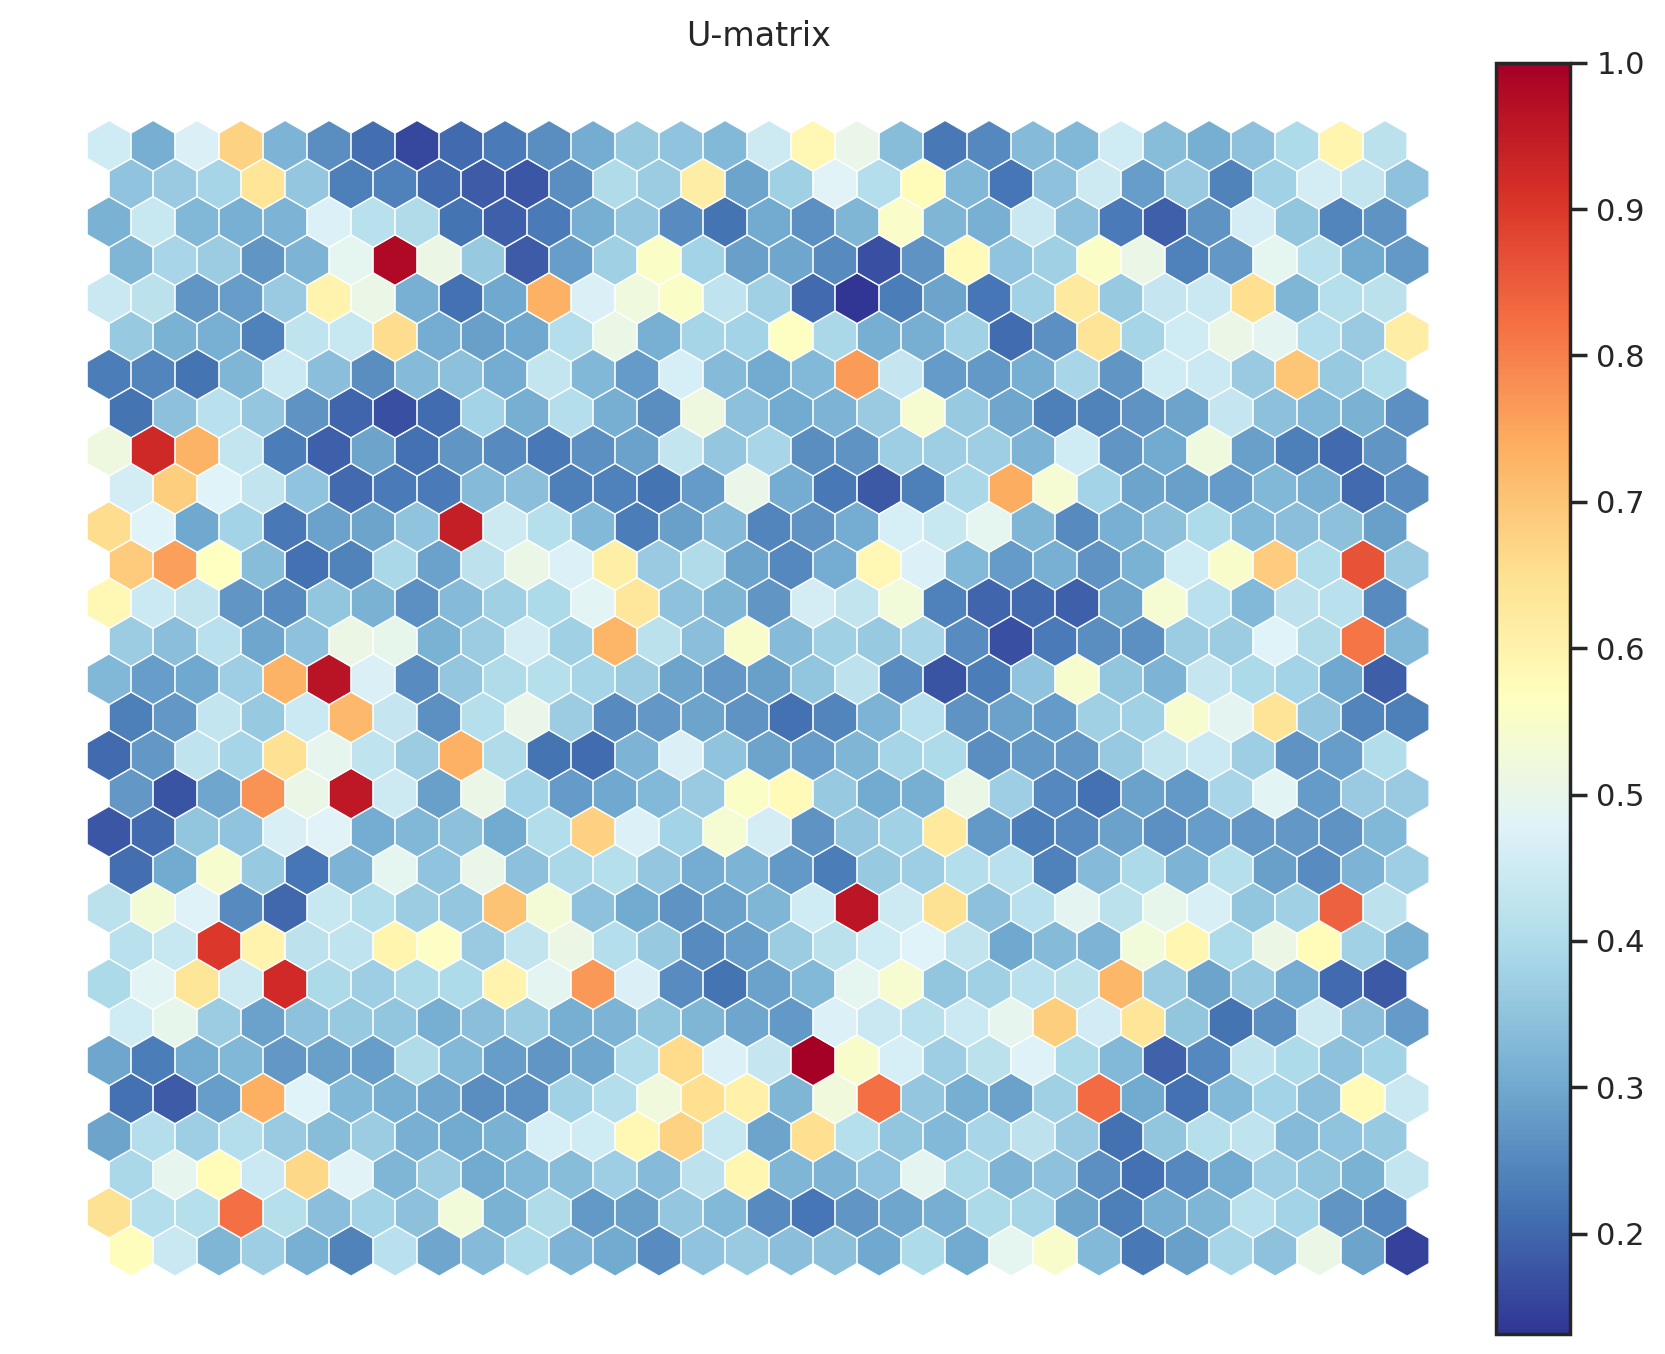

In [180]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r
                    )

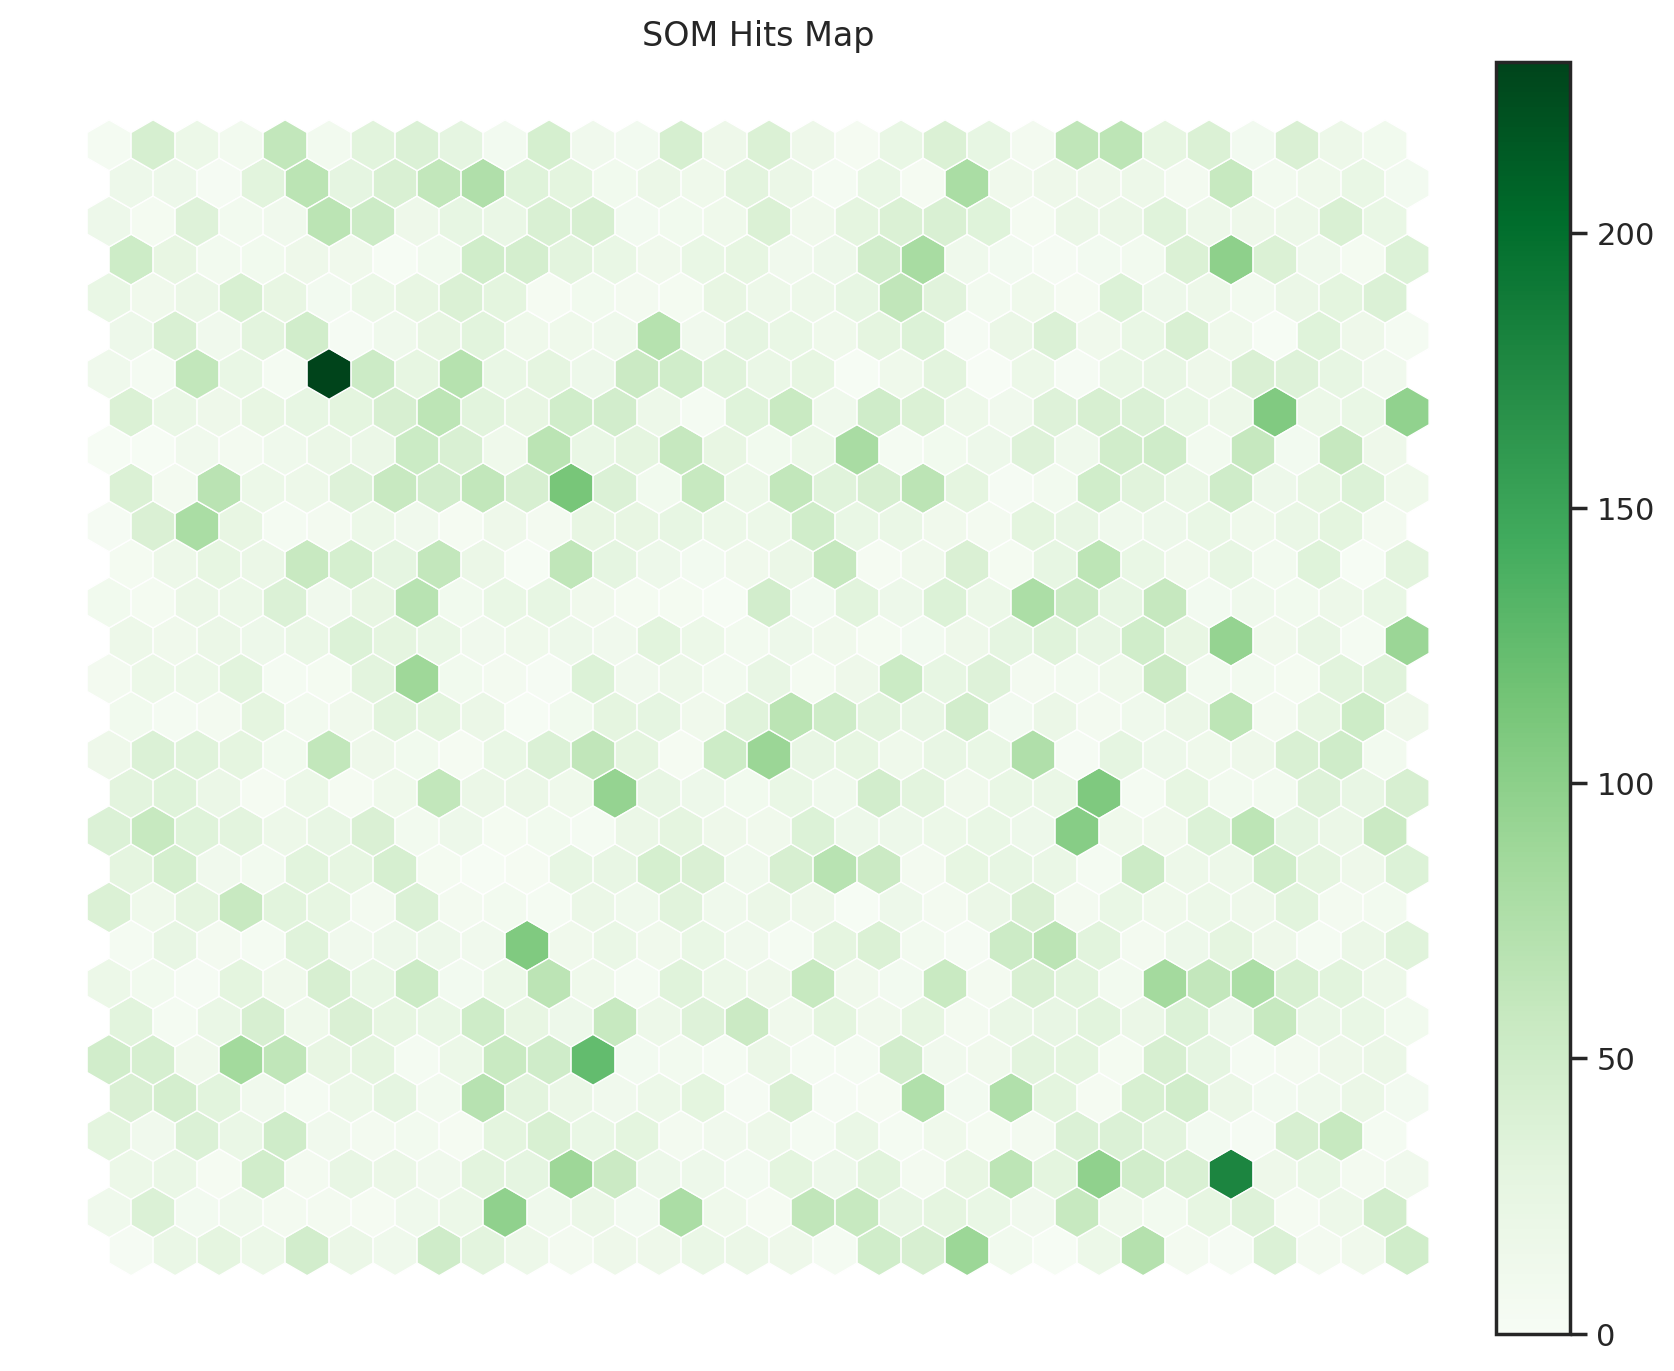

In [181]:
hitsmatrix = sm.activation_response(engagement_minmax_df.values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens
                    )


In [182]:
sm.quantization_error(engagement_minmax_df.values)

3.924144424216596

In [183]:
weights_flat = sm.get_weights().reshape((M*N),len(engagement_minmax_df.columns))
weights_flat.shape

(900, 46)

In [184]:
avg_silhouette = []
for nclus in range(1, 11):
    # Skip nclus == 1
    if nclus == 1:
        continue

    # cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
    # hc_labels = cluster.fit_predict(engagement_minmax_df)

    # # Calculate centroids based on these hierarchical clusters
    # centroids = []
    # for i in range(nclus):
    #     cluster_points = engagement_minmax_df[hc_labels == i]  # Get points belonging to cluster i
    #     centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    #     centroids.append(centroid)

    # centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=10, random_state=20)
    cluster_labels = kmclust.fit_predict(weights_flat)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(weights_flat, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.40284555246777043
For n_clusters = 3, the average silhouette_score is : 0.2987313817042625
For n_clusters = 4, the average silhouette_score is : 0.2681346318871468
For n_clusters = 5, the average silhouette_score is : 0.2519524806222601
For n_clusters = 6, the average silhouette_score is : 0.1824420095124065
For n_clusters = 7, the average silhouette_score is : 0.20240039087387218
For n_clusters = 8, the average silhouette_score is : 0.08295356926047993
For n_clusters = 9, the average silhouette_score is : 0.04700631798741677
For n_clusters = 10, the average silhouette_score is : 0.07846573458368224


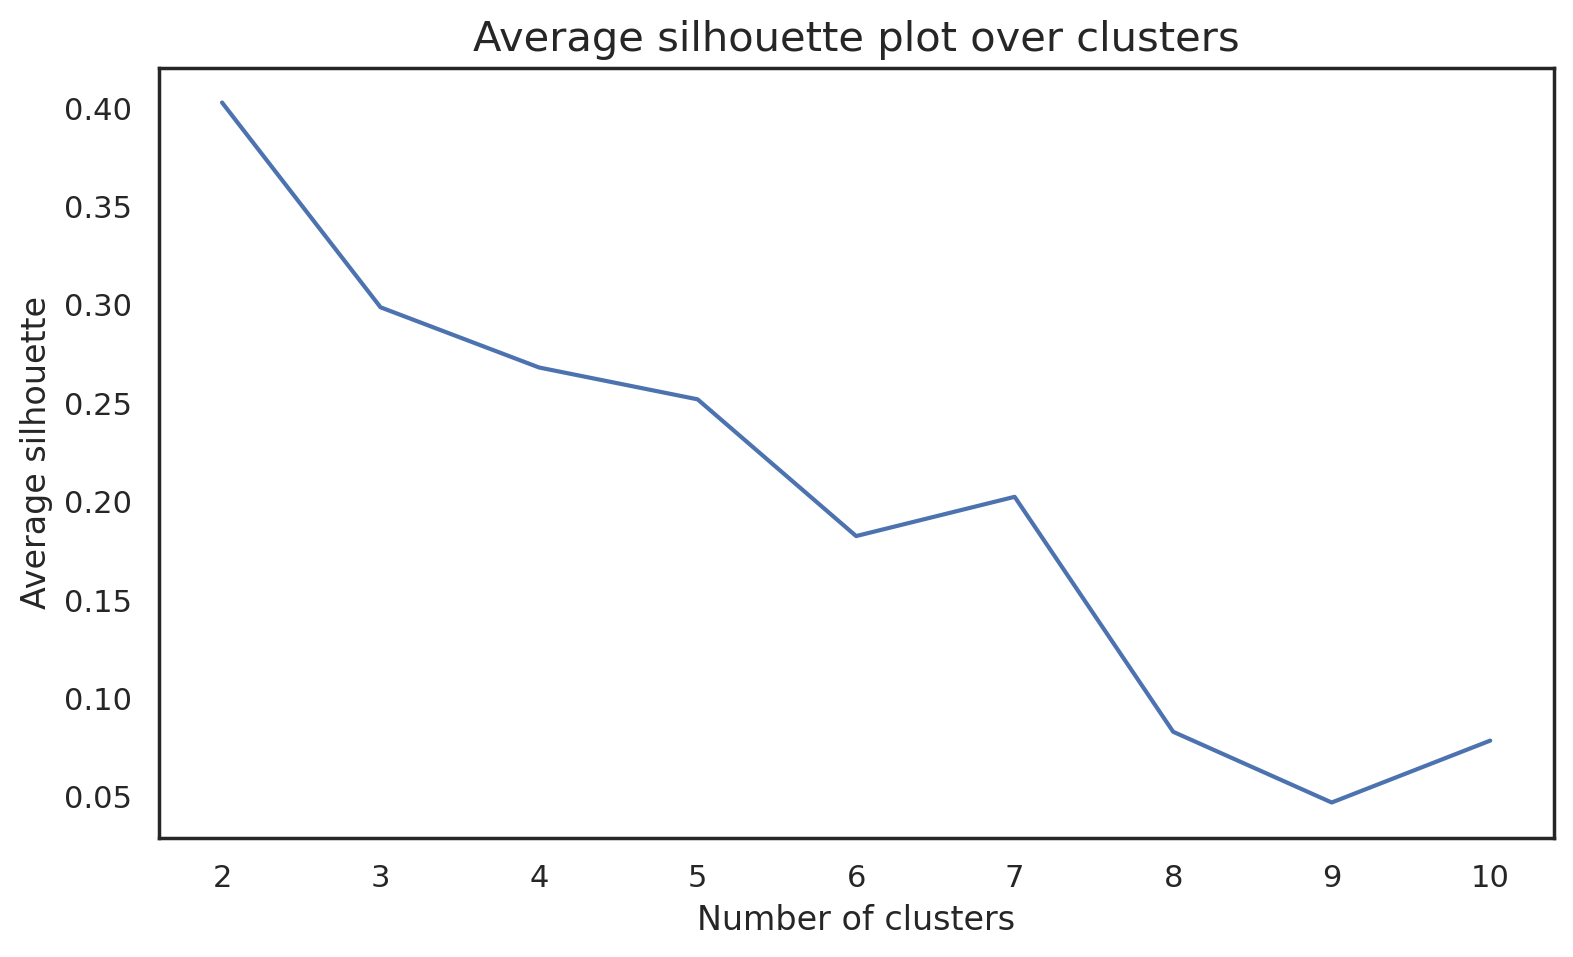

In [185]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(2, 11), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [92]:
# n_clusters = 3

# cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward") # Example params
# hc_labels = cluster.fit_predict(engagement_minmax_df)

# # Calculate centroids based on these hierarchical clusters
# centroids = []
# for i in range(nclus):
#     cluster_points = engagement_minmax_df[hc_labels == i]  # Get points belonging to cluster i
#     centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
#     centroids.append(centroid)

# centroids = np.array(centroids)

In [343]:
# Perform K-Means clustering on top of the MxN units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=20)
nodeclus_labels = kmeans.fit_predict(weights_flat)

In [ ]:
kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

In [ ]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=engagement_features)
df_nodes['label'] = nodeclus_labels
df_nodes.head()

In [ ]:
## This gets BMU coordinates, e.g. (4,4) for each data point
bmu_index = np.array([sm.winner(x) for x in engagement_minmax_df.values])

print(bmu_index.shape)

bmu_index

In [347]:
## This gets the cluster label from kmeans_matrix
som_final_labels = [kmeans_matrix[i[0]][i[1]] for i in bmu_index]

In [ ]:
df_final = pd.concat([
    engagement_minmax_df,
    pd.Series(som_final_labels, name='label', index=engagement_minmax_df.index)
], axis=1
)

df_final.head()

In [ ]:
# Characterizing the final clusters
df_final.groupby('label').mean()

In [ ]:
fig, ax = plt.subplots(figsize=(8,14))

hc_profile = df_final.groupby('label').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()